## Introduction
In today's data-driven world, understanding user behavior and its impact on outcomes is crucial. For educational institutions, analyzing the activity patterns of students can provide insights into their performance and help tailor interventions. One common area of interest is whether the time of day a student is active correlates with their academic performance. Specifically, we might want to investigate if students who are more active during late hours, often referred to as "night owls," have different academic outcomes compared to their peers.

In this analysis, we will explore a dataset containing student navigation events to determine if being a night owl is associated with lower average grades. We will start by preparing and cleaning the dataset, followed by conducting a hypothesis test to examine the relationship between late-night activity and academic performance.

To begin, let's load the necessary libraries, read the dataset, and perform some initial data cleaning and inspection:

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Load the CSV file into a DataFrame
events = pd.read_csv('./data/navigation_events.csv')

# Remove all null columns
events=events.dropna(axis=1,how='all')

# Display the first few rows of the DataFrame
events.head()

,id,type,action,event_time,session_id,object_id,membership_role,actor_id,event__object_type,event__object_name,event__object_extensions_asset_name,event__object_extensions_asset_type,event__object_extensions_http_method,event__attachment_type
0,a3bd94baaa440f4793ad08bb64ed3a8f,NavigationEvent,navigatedto,2033-03-27 03:08:48.947000+00:00,f8eac5633f79de90a77b33338b14dd8e,0878d2f171deae54c6a81acc6ffeba20,"[""Learner""]",LEARNER_1,Entity,attachment,file003.pdf,attachment,GET,pdf
1,0f137ee4ff1b603e3c9de17c5dc9a1d2,NavigationEvent,navigatedto,2033-03-30 16:23:40.909000+00:00,90d33cac1281c636931efa7646e1e1c3,0878d2f171deae54c6a81acc6ffeba20,"[""Learner""]",LEARNER_1,Entity,attachment,file003.pdf,attachment,GET,pdf
2,86109c5350e06d3d7fe0ec880f37193e,NavigationEvent,navigatedto,2033-03-25 12:57:06.195000+00:00,2c3cdb1505e1c2dbf93d70b499668328,aa6bffb0a91e4f737a943dfddad70a7b,"[""Learner""]",LEARNER_1,Entity,attachment,image006.png,attachment,GET,png
3,da5b96f601b39f14e2cc7de59bea35b9,NavigationEvent,navigatedto,2033-03-20 15:57:10.521000+00:00,bd87f5bcffda3d2f6de47cf02697f43b,aa6bffb0a91e4f737a943dfddad70a7b,"[""Learner""]",LEARNER_1,Entity,attachment,image006.png,attachment,GET,png
4,7959480d52ab4c94821c122e27a48cd3,NavigationEvent,navigatedto,2033-01-11 18:05:29.939000+00:00,d5c5f36d8bc0ebc001c374f9daec961b,aa6bffb0a91e4f737a943dfddad70a7b,"[""Learner""]",LEARNER_1,Entity,attachment,image006.png,attachment,GET,png


Before diving into the analysis, it's essential to thoroughly understand the dataset. This involves getting a sense of the data structure, identifying any potential issues, and performing necessary preprocessing steps. By inspecting the data, we can ensure it is clean and properly formatted, which is crucial for accurate analysis and visualization.

The following code block performs these initial exploratory steps:

In [2]:
# Get basic information about the DataFrame
events_info = events.info()

# Summary statistics of the data
summary_statistics = events.describe()

events['event_time'] = pd.to_datetime(events['event_time'], errors='coerce')

# Extract day of the week and hour from 'event_time'
events['day_of_week'] = events['event_time'].dt.day_name()
events['hour'] = events['event_time'].dt.hour

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62839 entries, 0 to 62838
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   id                                    62839 non-null  object
 1   type                                  62839 non-null  object
 2   action                                62839 non-null  object
 3   event_time                            62839 non-null  object
 4   session_id                            62839 non-null  object
 5   object_id                             62839 non-null  object
 6   membership_role                       62839 non-null  object
 7   actor_id                              62839 non-null  object
 8   event__object_type                    62839 non-null  object
 9   event__object_name                    36179 non-null  object
 10  event__object_extensions_asset_name   62839 non-null  object
 11  event__object_extensions_ass

### Visualizing Event Activity Patterns

To gain deeper insights into when students are most active, we can analyze the frequency of events based on the day of the week and the hour of the day. This visualization helps us understand the temporal patterns of student activity, which is crucial for identifying night owls and assessing their behavior.

The following code block performs the necessary steps to group the data, pivot it into a suitable format, and create a heatmap for visualization:

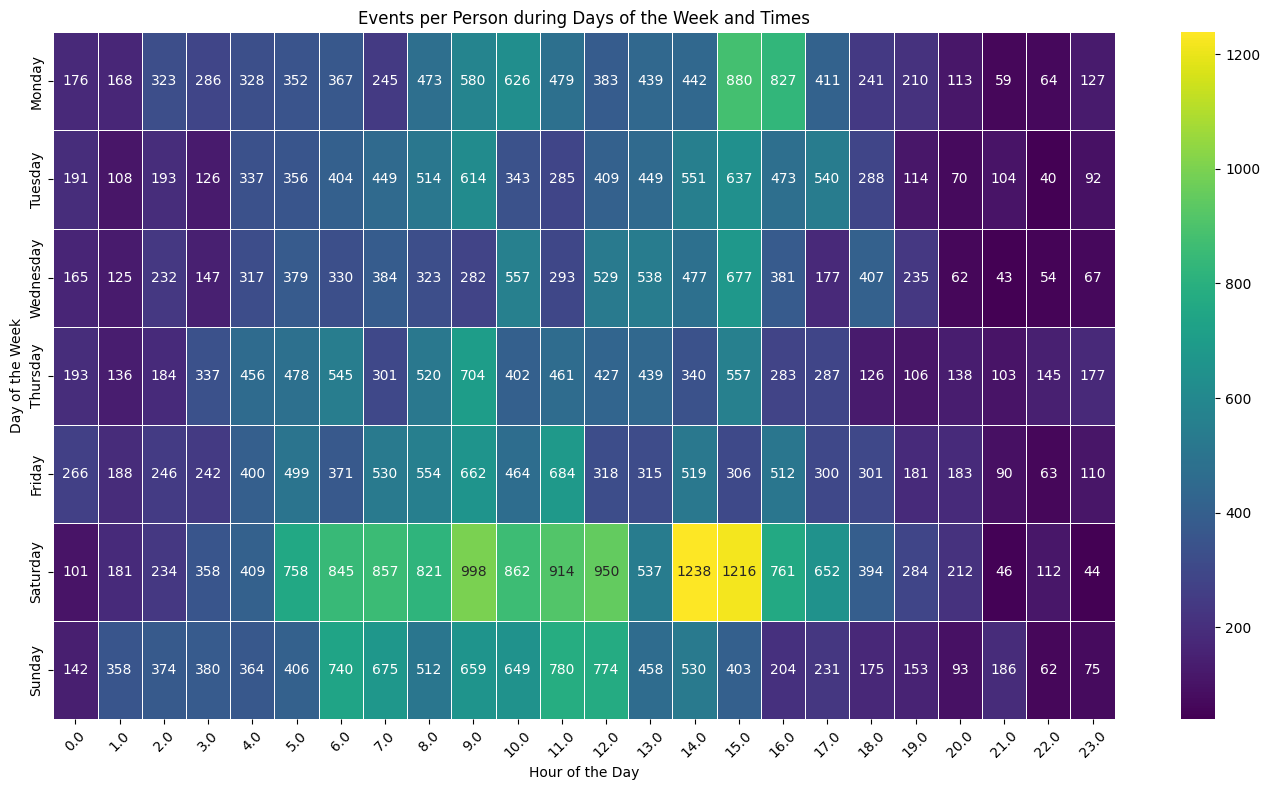

In [3]:
# Group by 'actor_id', 'day_of_week', and 'hour' and count the number of events
grouped = events.groupby(['actor_id', 'day_of_week', 'hour']).size().reset_index(name='event_count')

# Pivot the data to get days of the week as rows, hours as columns, and event counts as values
pivot_table = grouped.pivot_table(index='day_of_week', columns='hour', values='event_count', aggfunc='sum', fill_value=0)

# Reorder the days of the week for better visualization
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_table = pivot_table.reindex(days_order)

# Plotting the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(pivot_table, cmap='viridis', annot=True, fmt='d', linewidths=.5)
plt.title('Events per Person during Days of the Week and Times')
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Filtering and Preparing Learner Data

To analyze the behavior of learners specifically, we need to isolate the relevant subset of the dataset. This involves filtering the data to include only events associated with learners, standardizing the format of their IDs, and extracting the necessary time-related information. This preprocessing step ensures that our subsequent analyses are accurate and focused on the right population.

The following code block accomplishes these tasks:

In [4]:
learners_df = events[events['membership_role'] == '["Learner"]'].copy()

learners_df['actor_id'] = learners_df['actor_id'].astype(str)  # Convert to string type if not already
learners_df['actor_id'] = learners_df['actor_id'].str.replace('LEARNER_', '')
learners_df['actor_id'] = learners_df['actor_id'].astype(int)

# Extract hour from 'event_time'
learners_df['hour'] = learners_df['event_time'].dt.hour

learners_df.head()

,id,type,action,event_time,session_id,object_id,membership_role,actor_id,event__object_type,event__object_name,event__object_extensions_asset_name,event__object_extensions_asset_type,event__object_extensions_http_method,event__attachment_type,day_of_week,hour
0,a3bd94baaa440f4793ad08bb64ed3a8f,NavigationEvent,navigatedto,2033-03-27 03:08:48.947000+00:00,f8eac5633f79de90a77b33338b14dd8e,0878d2f171deae54c6a81acc6ffeba20,"[""Learner""]",1,Entity,attachment,file003.pdf,attachment,GET,pdf,Sunday,3.0
1,0f137ee4ff1b603e3c9de17c5dc9a1d2,NavigationEvent,navigatedto,2033-03-30 16:23:40.909000+00:00,90d33cac1281c636931efa7646e1e1c3,0878d2f171deae54c6a81acc6ffeba20,"[""Learner""]",1,Entity,attachment,file003.pdf,attachment,GET,pdf,Wednesday,16.0
2,86109c5350e06d3d7fe0ec880f37193e,NavigationEvent,navigatedto,2033-03-25 12:57:06.195000+00:00,2c3cdb1505e1c2dbf93d70b499668328,aa6bffb0a91e4f737a943dfddad70a7b,"[""Learner""]",1,Entity,attachment,image006.png,attachment,GET,png,Friday,12.0
3,da5b96f601b39f14e2cc7de59bea35b9,NavigationEvent,navigatedto,2033-03-20 15:57:10.521000+00:00,bd87f5bcffda3d2f6de47cf02697f43b,aa6bffb0a91e4f737a943dfddad70a7b,"[""Learner""]",1,Entity,attachment,image006.png,attachment,GET,png,Sunday,15.0
4,7959480d52ab4c94821c122e27a48cd3,NavigationEvent,navigatedto,2033-01-11 18:05:29.939000+00:00,d5c5f36d8bc0ebc001c374f9daec961b,aa6bffb0a91e4f737a943dfddad70a7b,"[""Learner""]",1,Entity,attachment,image006.png,attachment,GET,png,Tuesday,18.0


### Analyzing and Visualizing Hourly Activity for a Specific Learner
To gain detailed insights into the hourly activity of a specific learner, we need to group the data by hour and visualize the frequency of events throughout the day. This process helps identify patterns in the learner's behavior and understand their engagement levels at different times. The following code block performs these tasks:

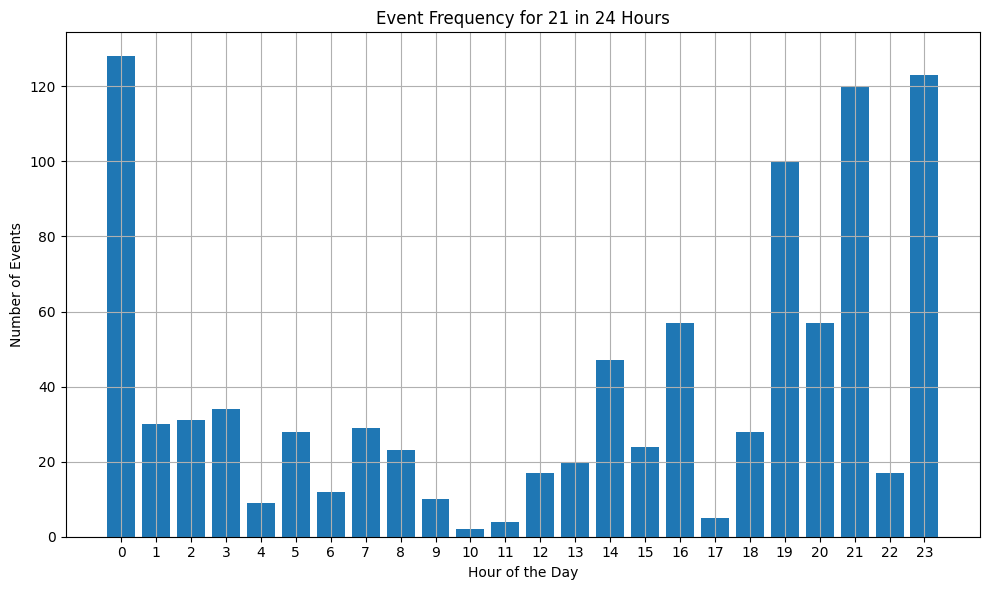

In [5]:
# Group by 'actor_id' and 'hour' and count the number of events
grouped = learners_df.groupby(['actor_id', 'hour']).size().reset_index(name='event_count')

# Select data for a specific learner, e.g., '21'
learner_id = 21
learner_data = grouped[grouped['actor_id'] == learner_id]

# Ensure all hours are represented, even if some have zero events
all_hours = pd.DataFrame({'hour': range(24)})
learner_data = all_hours.merge(learner_data, on='hour', how='left').fillna(0)

# Plotting the bar plot
plt.figure(figsize=(10, 6))
plt.bar(learner_data['hour'], learner_data['event_count'])
plt.title(f'Event Frequency for {learner_id} in 24 Hours')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Events')
plt.xticks(range(24))
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

Here is how a late night owl is classified:

#### Threshold:
The threshold refers to the proportion of late-night activity relative to overall activity during non-class hours. It represents the fraction of activity during late-night hours (typically between 8 PM and 5 AM) that must be met by a user to be classified as a late-night user. For example, if the threshold is set at 0.05 (5%), it means that at least 5% of a user's activity should occur during late-night hours for them to be considered a late-night user.

#### Noise During Class Hours:
Noise during class hours refers to the high traffic of users engaging in activities related to classes or participation, typically occurring between 9 AM and 4 PM. This noise includes activities such as attending lectures, participating in discussions, or submitting assignments, which may not necessarily reflect users' natural habits or patterns outside of academic commitments.

To mitigate the impact of this noise, we exclude activities during class hours from our analysis of overall user activity. This allows us to focus specifically on the time periods outside of class hours when users are more likely to exhibit their natural behavior patterns. By excluding class hours from the calculation of overall activity, we aim to ensure that our classification of late-night users is based on their genuine habits rather than academic-related activities.

In [6]:
import late_users
night_owls = late_users.classify_night_owl(learners_df, 0.40)
night_owls

[11, 20, 21, 22, 24, 27, 28, 29, 30, 33, 35, 37, 40]

### Merging and Cleaning Grade Data
To perform an analysis on student grades, especially in the context of comparing night owls to other students, we need to clean and merge datasets containing grade information. This process ensures that our data is in a usable format and that any unnecessary or redundant information is removed. The following code block outlines the steps to tidy up and merge the grade datasets:

In [7]:
grades_tidy = pd.read_csv('./data/data.csv')
grades_messy = pd.read_csv('./data/gradebook.csv')

grades_messy['Student'] = grades_messy['Student'].str.replace('LEARNER_', '')
grades_messy.drop([0,1], axis = 0, inplace = True)
grades_messy.drop(grades_messy.columns[list(range(1,8))], axis = 1, inplace = True)
grades_messy = pd.to_numeric(grades_messy["Student"])

grades = pd.merge(grades_tidy, grades_messy, sort="Student")
grades.drop("engagement", axis = 1, inplace = True)
grades.head()


,Student,Assignment 1 Current Score,Assignment 2 Current Score,Assignment 3 Current Score,Participation & engagement Current Score,Current Score
0,1,79,84.0,73.0,90.0,80.9
1,2,93,85.0,95.0,60.0,84.6
2,3,94,92.0,82.0,90.0,89.0
3,4,88,76.0,75.0,100.0,82.9
4,5,91,82.0,84.0,100.0,88.0


### Hypothesis Test Explanation
Objective:
The objective of this hypothesis test is to investigate whether students who are "night owls" (i.e., those who are active during late hours) have, on average, lower grades compared to other students.

Hypotheses:
> Null Hypothesis (H0): There is no difference in the average grades between night owl students and other students.
* 𝐻<sub>0</sub>: 𝜇<sub>night owls</sub> = 𝜇<sub>others</sub> 

> Alternative Hypothesis (H1): Night owl students have a lower average grade compared to other students.
* 𝐻<sub>0</sub>: 𝜇<sub>night owls</sub> < 𝜇<sub>others</sub>
 

##### Assumptions:
- The data for both groups (night owls and others) are independent and identically distributed.
- The grades for both groups follow a normal distribution (or the sample size is sufficiently large for the Central Limit Theorem to apply).


##### Test Procedure:
1. Data Extraction:
    - Grades are extracted for two groups: night owls and other students.
2. Independent Samples t-Test:
    - An independent samples t-test is performed to compare the mean grades of the two groups.
    - The t-test assesses whether the difference in means between the two groups is statistically significant.
3. Hypothesis Testing:
    - The one-tailed t-test is used, with the alternative hypothesis indicating that night owl students have lower grades.
    - The significance level (α) is set to 0.05.
4. Interpretation of Results:
    - If the p-value is less than the significance level (α), we reject the null hypothesis.
5. Conclusion: There is sufficient evidence to suggest that night owl students have a lower average grade.
    - If the p-value is greater than or equal to the significance level (α), we fail to reject the null hypothesis.

In [8]:
# Extract grades for night owls and other students
night_owl_grades = grades[grades['Student'].isin(night_owls)]['Current Score']
other_grades = grades[~grades['Student'].isin(night_owls)]['Current Score']

# Perform independent samples t-test (one-tailed)
t_stat, p_value = ttest_ind(night_owl_grades, other_grades, alternative='less')

# Print the results
print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: Night owls have a lower average grade.")
else:
    print("Fail to reject the null hypothesis: No evidence that night owls have a lower average grade.")

t-statistic: -0.08362856410294126
p-value: 0.4669363668330153
Fail to reject the null hypothesis: No evidence that night owls have a lower average grade.


## Results:
- t-Statistic: The t-statistic value quantifies the difference between the means of the two groups.
- p-Value: The p-value indicates the probability of observing the obtained results (or more extreme) under the assumption that the null hypothesis is true.

##### Interpretation of Results:
- If the p-value is less than α (0.05), we reject the null hypothesis and conclude that there is evidence to suggest that night owl students have a lower average grade.
- If the p-value is greater than or equal to α (0.05), we fail to reject the null hypothesis, indicating no significant evidence of a difference in average grades between night owls and other students.


Conclusion:
Based on the results of the hypothesis test, we will either reject or fail to reject the null hypothesis, providing insights into the relationship between late-night activity and academic performance.